In [ ]:
!pip install face-alignment

In [ ]:
pip install pydub

In [ ]:
%matplotlib inline
import face_alignment
from skimage import io,transform,data,color,feature
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
import skimage.io as io
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score , GridSearchCV
from sklearn.svm import LinearSVC
import numpy as np
from numba import jit, cuda
import pickle
import timeit
from os import listdir
from matplotlib import image
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import re
import string

from __future__ import print_function
import argparse
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
import dlib
from imutils.face_utils import FaceAligner
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [ ]:
import librosa
import soundfile
import glob
import shutil
import wave
import contextlib
from pydub import AudioSegment
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# put here the path to the mode
model = pickle.load(open("faceDetection2.sav", 'rb'))
print(model)
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


In [ ]:
#load the model 
voice_model = pickle.load(open('voice_model.pkl', 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neural_network.multilayer_perceptron module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neural_network. Anything that cannot be imported from sklearn.neural_network is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.label module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.21.2 when

In [ ]:
def getFaceAlign(img):
  io.imsave('testt.jpg',img)
  preds = fa.get_landmarks(img)
  if preds == None:
    #print('Warning: No faces were detected.')
    return None,0
  if preds!=None:
    mnXY= np.min(np.min(preds, axis=1), axis=0)
    mxXY= np.max(np.max(preds, axis=1), axis=0)
    mxY=int(mxXY[0]+2)
    mnX=int(mnXY[1])-8
    mxX=int(mxXY[1])
    if mnX < 0:
       mnX=0
    if int(mxXY[0]+2) >= img.shape[1]:
      mxY=img.shape[1]-1
    if (img.shape[0]-2-mnX) <= 40:
      return img[mnX:img.shape[0]-2,int(mnXY[0])-2:mxY],1
    else:
      return img[mnX:mnX+50,int(mnXY[0])-2:mxY],1   # were 40 instead of 50

In [ ]:
def non_max_suppression_fast(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:,2]
    y1 = boxes[:,0]
    x2 = boxes[:,3]
    y2 = boxes[:,1]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    return boxes[pick].astype("int")

In [ ]:
def find(image):
    boxes=[[i,i+k,j,int(j+k)] for k in [35,40,45,50] for i in range(0,image.shape[0]-k,10) for j in range(0,image.shape[1]-k,10) if (model.predict([feature.hog(transform.resize(image[i:i+k,j:int(j+k)],(48,48)))])[0] == 1)]
    return boxes

In [ ]:
import sys

from torch.nn.modules.activation import ReLU
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


def SeparableConv2D(in_channels, out_channels, kernel=3):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size=kernel, stride=1, groups=in_channels,padding=1, bias=False),
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
    )

class ResidualXceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=3):
        super(ResidualXceptionBlock, self).__init__()
        global device

        self.depthwise_conv1 = SeparableConv2D(in_channels, out_channels, kernel).to(device)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.depthwise_conv2 = SeparableConv2D(out_channels, out_channels, kernel).to(device)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # self.padd = nn.ZeroPad2d(22)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        # self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, padding=22, bias=False)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.residual_bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # residual branch
        residual = self.residual_conv(x)
        residual = self.residual_bn(residual)
        
        # print('input',x.shape)
        # feature extraction branch
        x = self.depthwise_conv1(x)
        # print('conv1',x.shape)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.depthwise_conv2(x)
        x = self.bn2(x)
        # print('conv2',x.shape)

        # x = self.padd(x)
        x = self.maxpool(x)
        # print(x[:,:, 11:22, 11:22])
        # print('max_pooling',x.shape)
        # print('res',residual.shape)
        return x + residual

class Mini_Xception(nn.Module):
    def __init__(self):
        super(Mini_Xception, self).__init__()
        self.conv1 = conv_bn_relu(1, 8, kernel_size=3, stride=1, padding=0)
        self.conv2 = conv_bn_relu(8, 8, kernel_size=3, stride=1, padding=0)
        self.residual_blocks = nn.ModuleList([
            ResidualXceptionBlock(8 , 16).to(device),
            ResidualXceptionBlock(16, 32).to(device),
            ResidualXceptionBlock(32, 64).to(device),
            ResidualXceptionBlock(64, 128).to(device)            
        ])
        self.conv3 = nn.Conv2d(128, 7, kernel_size=3, stride=1, padding=1)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)

        for block in self.residual_blocks:
            x = block(x)
            # print('ith block', x.shape, block.device)

        # print('blocks:',x.shape)
        x = self.conv3(x)
        # print('conv3',x.shape)
        x = self.global_avg_pool(x)
        # # x = self.softmax(x)

        return x

def get_label_emotion(label : int) -> str:
    label_emotion_map = { 
        0: 'Angry',
        1: 'Disgust', 
        2: 'Fear', 
        3: 'Happy', 
        4: 'Sad', 
        5: 'Surprise', 
        6: 'Neutral'        
    }
    return label_emotion_map[label]


def pr(img):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  mini_xception = Mini_Xception().to(device)
  mini_xception.eval()

  # Load model
  # put here the path to the model
  checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/weights_epoch_75.pth.tar')
  mini_xception.load_state_dict(checkpoint['mini_xception'])

    
  input_face = cv2.resize(img, (48,48))
  input_face = cv2.equalizeHist(input_face)
  input_face = transforms.ToTensor()(input_face).to(device)
  input_face = torch.unsqueeze(input_face, 0)

  with torch.no_grad():
      input_face = input_face.to(device)
      emotion = mini_xception(input_face)
      # print(f'\ntime={(time.time()-t) * 1000 } ms')

      torch.set_printoptions(precision=6)
      softmax = torch.nn.Softmax()
      emotions_soft = softmax(emotion.squeeze()).reshape(-1,1).cpu().detach().numpy()
      emotions_soft = np.round(emotions_soft, 3)
      for i, em in enumerate(emotions_soft):
          em = round(em.item(),3)
          # print(f'{get_label_emotion(i)} : {em}')

      emotion = torch.argmax(emotion)                
      percentage = round(emotions_soft[emotion].item(), 2)
      emotion = emotion.squeeze().cpu().detach().item()
      emotion = get_label_emotion(emotion)
      return emotion

# Voice analysis

In [ ]:
#DataFlair - Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(X, mfcc, chroma, mel,sample_rate):   
    result=np.array([])
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    if chroma:
        stft=np.abs(librosa.stft(X))
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
    if mel:
        mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [ ]:
def predict_voice(file):
    x=[]
    y=[]
    y, s = librosa.load(file) # Downsample 44.1kHz to 8kHz
    feature=extract_feature(X=y, mfcc=True, chroma=True, mel=True,sample_rate=s)
    x.append(feature)
    y_pred=voice_model.predict(x)
    emotion = y_pred[0]
    return emotion

## Split Audio

In [ ]:
def get_duration(fname):
    with contextlib.closing(wave.open(fname,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
        return duration

In [ ]:
def get_emotion_dic(fname):
  duration = get_duration(fname) 
  
  # frames/ is the directory to stores audio frames
  dir='frames'
  if not os.path.exists(dir):
    os.makedirs(dir)
  else:
    shutil.rmtree(dir)           
    os.makedirs(dir)  
  emotion_dic={'bad':0,'medium':0,'good':0}
  originalAudio = AudioSegment.from_wav(fname)
  for i in range(0,int(duration),3):
      #newAudio = AudioSegment.from_wav("ted2.wav")
      newAudio = originalAudio[i*1000:(i+3)*1000]
      newAudio.export('frames/'+str(i)+'.wav', format="wav") #Exports to a wav file in the current path.
      emotion = predict_voice('frames/'+str(i)+'.wav') 
      emotion_dic[emotion]+=1
  return emotion_dic

# **Answers Similarity**


In [ ]:
!pip install transformers
from transformers import AutoTokenizer
!pip install pytorch-pretrained-bert
from pytorch_pretrained_bert import BertModel

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def clean2_text(text):
  #remove some of stopwords as 'a, an, the'
  txt = clean_text(text)
  words = txt.split(' ')
  aft_remove = [w for w in words if w not in ['a', 'an', 'the','of', 'that', '']]
  return ' '.join(aft_remove)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
class Similarity_Model(nn.Module):
    def __init__(self, output_dim, n_layers, hidden_dim, freeze_bert):
        super(Similarity_Model,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        
        #bert Model and Freeze the BERT model
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        if freeze_bert:
            for p in self.bert_model.parameters():
                p.requires_grad = False

        #LSTM layers
        # self.lstm = nn.LSTM(768, hidden_dim, n_layers, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear layer
        self.fc = nn.Linear(768, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, input_ids, attention_masks, token_type_ids, hidden):
        batch_size = input_ids.size(0)

        sequence_output, pooled_output = self.bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids) 
        # print("seq  " , len(sequence_output))
        
        # lstm_out, hidden = self.lstm(sequence_output[0], hidden)

        # lstm_out = lstm_out.permute(0,2,1)
        
        # out_max = F.max_pool1d(lstm_out, kernel_size=lstm_out.shape[2])
        # out_avg = F.avg_pool1d(lstm_out, kernel_size=lstm_out.shape[2])
        
        # out = torch.cat((out_avg, out_max), dim=1)
        # out = out.permute(0,2,1)

        # dropout and fully connected layer
        out = self.dropout(pooled_output)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        out = sig_out.view(batch_size, -1)

        out = out[:, -1]

        return out, hidden

    def init_hidden(self, batch_size):
        # initialize hidden states with sizes n_layers x batch_size x hidden_dim
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
no_layers = 1
output_dim = 1
hidden_dim = 128
Freeze_bert = False
Similar_Model = Similarity_Model(output_dim, no_layers, hidden_dim, Freeze_bert)
#moving to gpu
Similar_Model.to(device)
Similar_Model.eval()

Similar_Model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Snli_TechSimilarity.pt"))

<All keys matched successfully>

In [ ]:
def predict_similarity(ans1, ans2):
  sentence1 = clean2_text(ans1)
  sentence2 = clean2_text(ans2)
  print(sentence1, sentence2)
  encoded_pair = tokenizer(  sentence1, sentence2, 
      add_special_tokens=True,
      return_tensors='pt'  # Return torch.Tensor objects
  )
  text, attention, token_ids = encoded_pair['input_ids'].expand(1,-1), encoded_pair['attention_mask'].expand(1,-1), encoded_pair['token_type_ids'].expand(1,-1)
  inputs, attention, token_ids = text.to(device), attention.to(device), token_ids.to(device)
  h = Similar_Model.init_hidden(1)
  h = tuple([each.data for each in h])
  output, _ = Similar_Model(inputs, attention, token_ids, h)
  return str(output.item())

# **Speech Recognition**

In [ ]:
!pip install google-cloud
!pip install google-cloud-speech

In [ ]:
import numpy as np
import scipy.io.wavfile as wav
import io as ar
import os
from google.cloud import speech

In [ ]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'avian-tract-283207-f1553ac44767.json'
client = speech.SpeechClient()

In [ ]:
def SpeechRecognition(audiof):
  x, s = librosa.load(audiof)
  soundfile.write('tmp.wav', x, s)
  with ar.open('/content/tmp.wav','rb') as audio_file:
    content = audio_file.read()
  audio = speech.RecognitionAudio(content=content)
  config = speech.RecognitionConfig(
      encoding = speech.RecognitionConfig.AudioEncoding.LINEAR16,
      language_code = 'en-US')
  operation = client.long_running_recognize(config=config, audio=audio)
  print("Waiting for operation to complete...")
  response = operation.result(timeout=90)
  answer = ""
  for result in response.results:
      # print('Transcript: {}'.format(result.alternatives[0].transcript))
      answer += result.alternatives[0].transcript
  return answer    

# **Routes**


In [ ]:
!pip install flask-ngrok
!pip install -U flask-cors

Requirement already up-to-date: flask-cors in /usr/local/lib/python3.7/dist-packages (3.0.10)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://22b3cf5f8fb8.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
recieved data:  

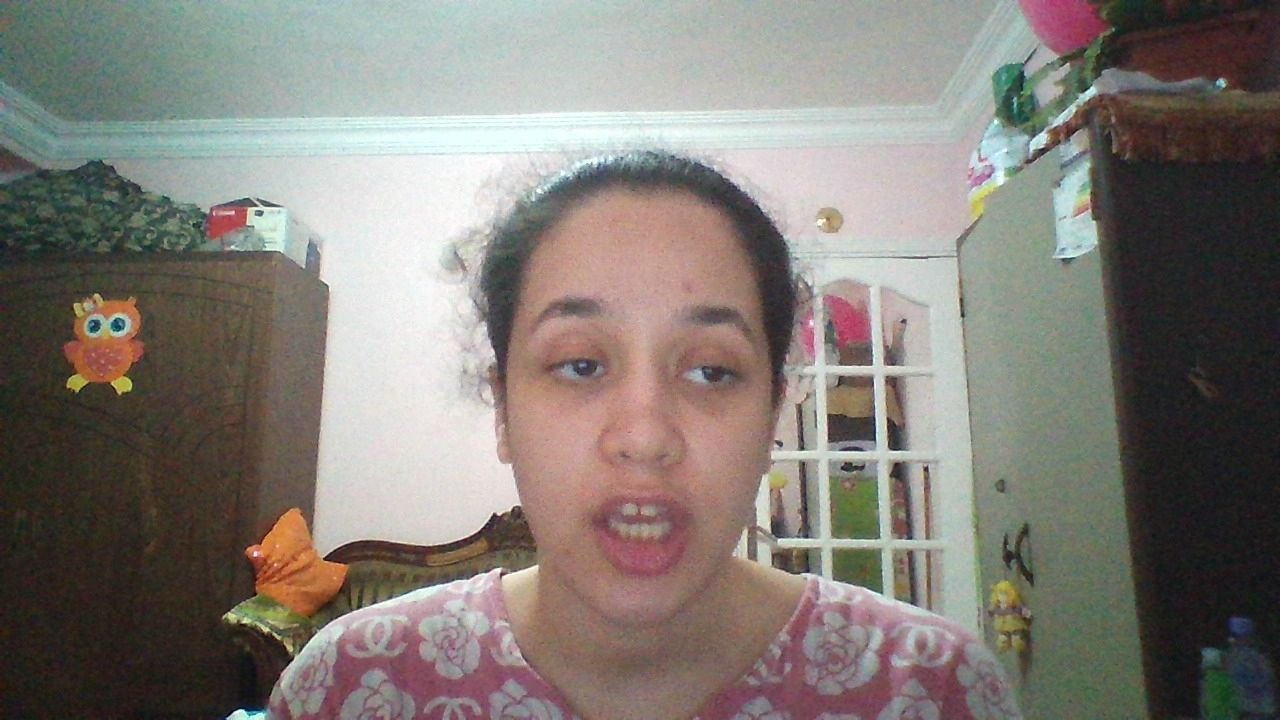

/usr/local/lib/python3.7/dist-packages/face_alignment/api.py:132: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")
127.0.0.1 - - [19/Jul/2021 04:21:24] "POST /predict HTTP/1.1" 200 -


Stop words are said to be useless data for a search engine. There are stop words such as was, were, is, am, the, a, an, how, why, and many more. In Natural Language Processing, we eliminate the stop words to understand and analyze the meaning of a sentence.


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Waiting for operation to complete...


127.0.0.1 - - [19/Jul/2021 04:21:35] "POST /predictSimilarity HTTP/1.1" 200 -


like in the old written words in English language
stop words are said to be useless data for search engine there are stop words such as was were is am how why and many more in natural language processing we eliminate stop words to understand and analyze meaning sentence like in old written words in english language
fukc probability:  0.23884132504463196
recieved data:  

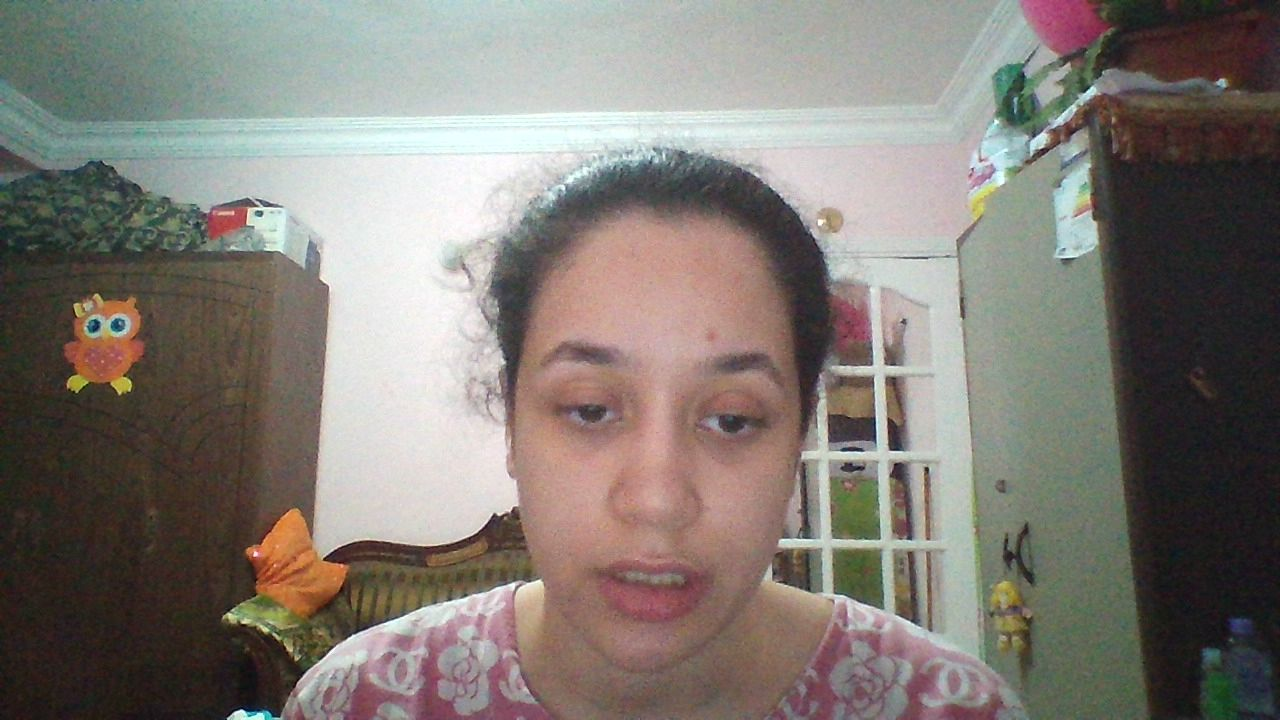

/usr/local/lib/python3.7/dist-packages/face_alignment/api.py:132: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")
127.0.0.1 - - [19/Jul/2021 04:21:42] "POST /predict HTTP/1.1" 200 -


TF-IDF or Term Frequency-Inverse Document Frequency indicates the importance of a word in a set. It helps in information retrieval with numerical statistics. For a specific document, TF-IDF shows a frequency that helps identify the keywords in a document.


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Waiting for operation to complete...


127.0.0.1 - - [19/Jul/2021 04:21:58] "POST /predictSimilarity HTTP/1.1" 200 -


do the importance of the word to choose which word with would be representative of what we need
tfidf or term frequencyinverse document frequency indicates importance word in set it helps in information retrieval with numerical statistics for specific document tfidf shows frequency helps identify keywords in document do importance word to choose which word with would be representative what we need
fukc probability:  0.06287149339914322
Syntactic analysis is a technique of analyzing sentences to extract meaning from it. Using syntactic analysis, a machine can analyze and understand the order of words arranged in a sentence. NLP employs grammar rules of a language that helps in the syntactic analysis of the combination and order of words in documents.


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Waiting for operation to complete...


127.0.0.1 - - [19/Jul/2021 04:22:04] "POST /predictSimilarity HTTP/1.1" 200 -



syntactic analysis is technique analyzing sentences to extract meaning from it using syntactic analysis machine can analyze and understand order words arranged in sentence nlp employs grammar rules language helps in syntactic analysis combination and order words in documents 
fukc probability:  0.10315144062042236
recieved data:  
Semantic analysis helps make a machine understand the meaning of a text. It uses various algorithms for the interpretation of words in sentences. It also helps understand the structure of a sentence.

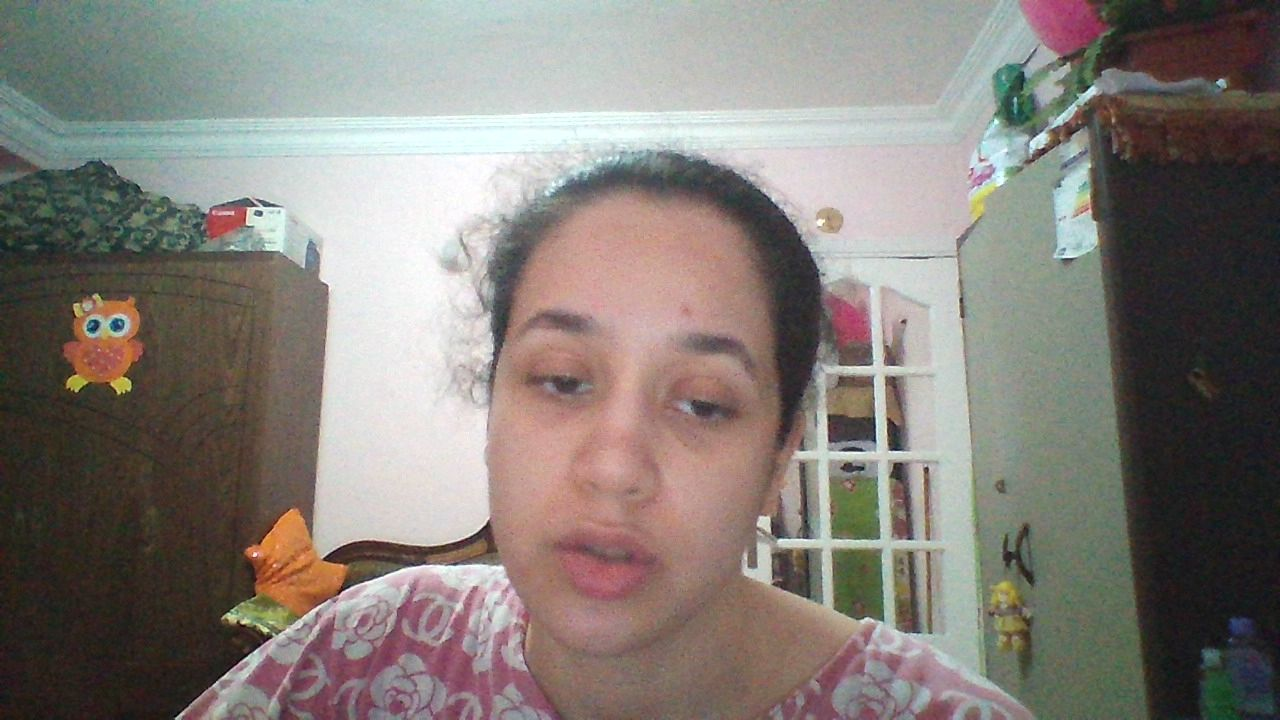

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/face_alignment/api.py:132: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")
127.0.0.1 - - [19/Jul/2021 04:22:12] "POST /predict HTTP/1.1" 200 -


Waiting for operation to complete...


127.0.0.1 - - [19/Jul/2021 04:22:14] "POST /predictSimilarity HTTP/1.1" 200 -



semantic analysis helps make machine understand meaning text it uses various algorithms for interpretation words in sentences it also helps understand structure sentence 
fukc probability:  0.8398318290710449
recieved data:  

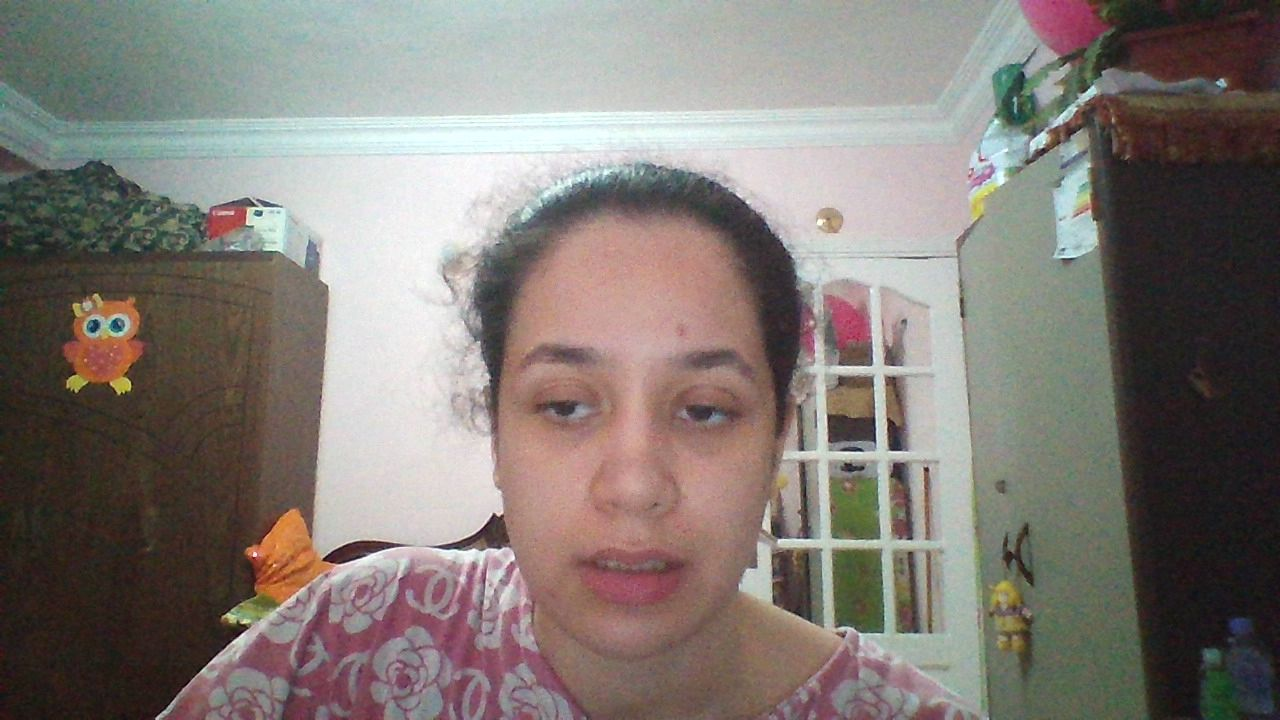

/usr/local/lib/python3.7/dist-packages/face_alignment/api.py:132: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")
127.0.0.1 - - [19/Jul/2021 04:22:32] "POST /predict HTTP/1.1" 200 -


Parsing is the method to identify and understand the syntactic structure of a text. It is done by analyzing the individual elements of the text. The machine parses the text one word at a time, then two at a time, further three, and so on.


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Waiting for operation to complete...


127.0.0.1 - - [19/Jul/2021 04:22:48] "POST /predictSimilarity HTTP/1.1" 200 -


Boston and forcing is the is to split the word into what
parsing is method to identify and understand syntactic structure text it is done by analyzing individual elements text machine parses text one word at time then two at time further three and so on boston and forcing is is to split word into what
fukc probability:  0.00198111729696393
recieved data:  

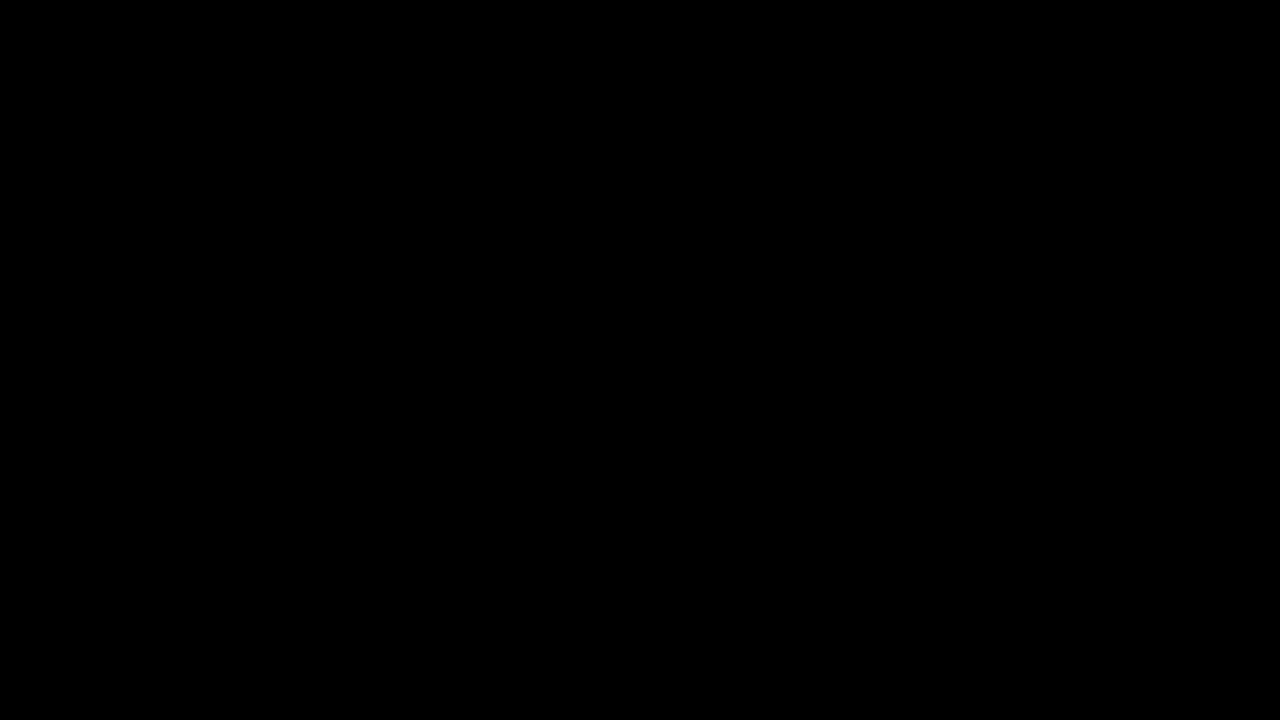

127.0.0.1 - - [19/Jul/2021 04:22:49] "POST /predict HTTP/1.1" 200 -


recieved data:  

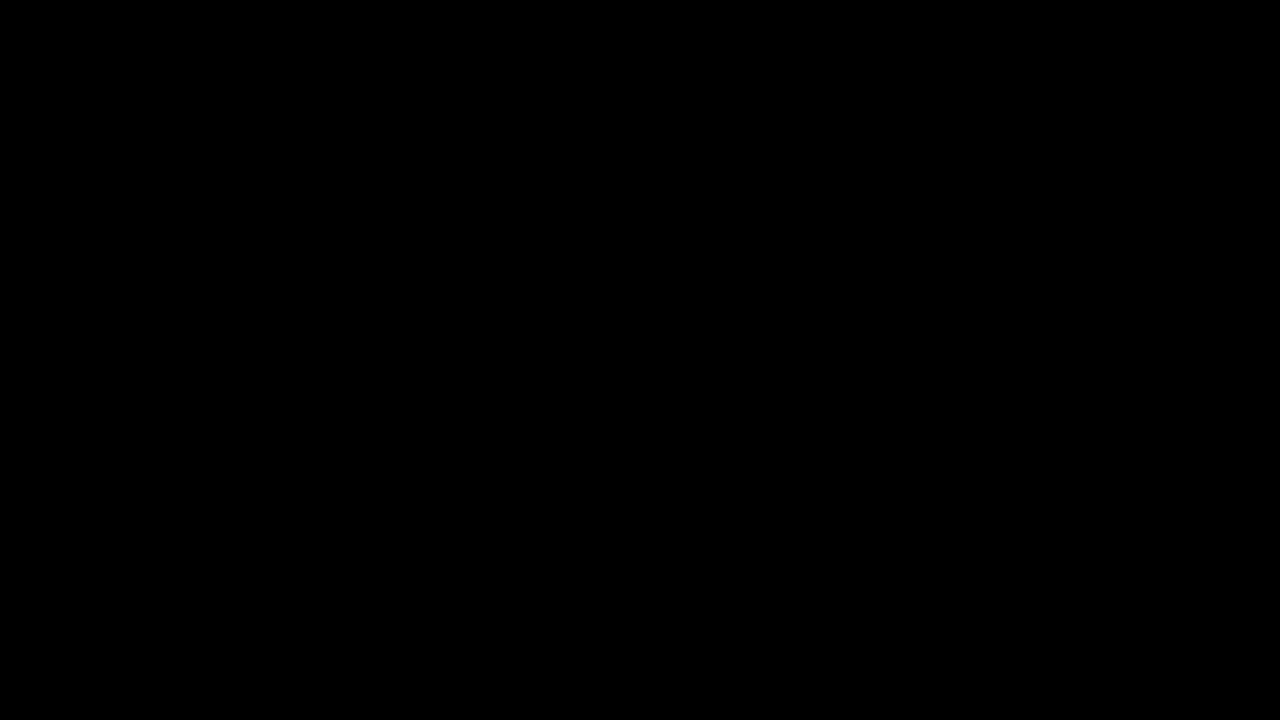

127.0.0.1 - - [19/Jul/2021 04:22:51] "POST /predict HTTP/1.1" 200 -


recieved data:  

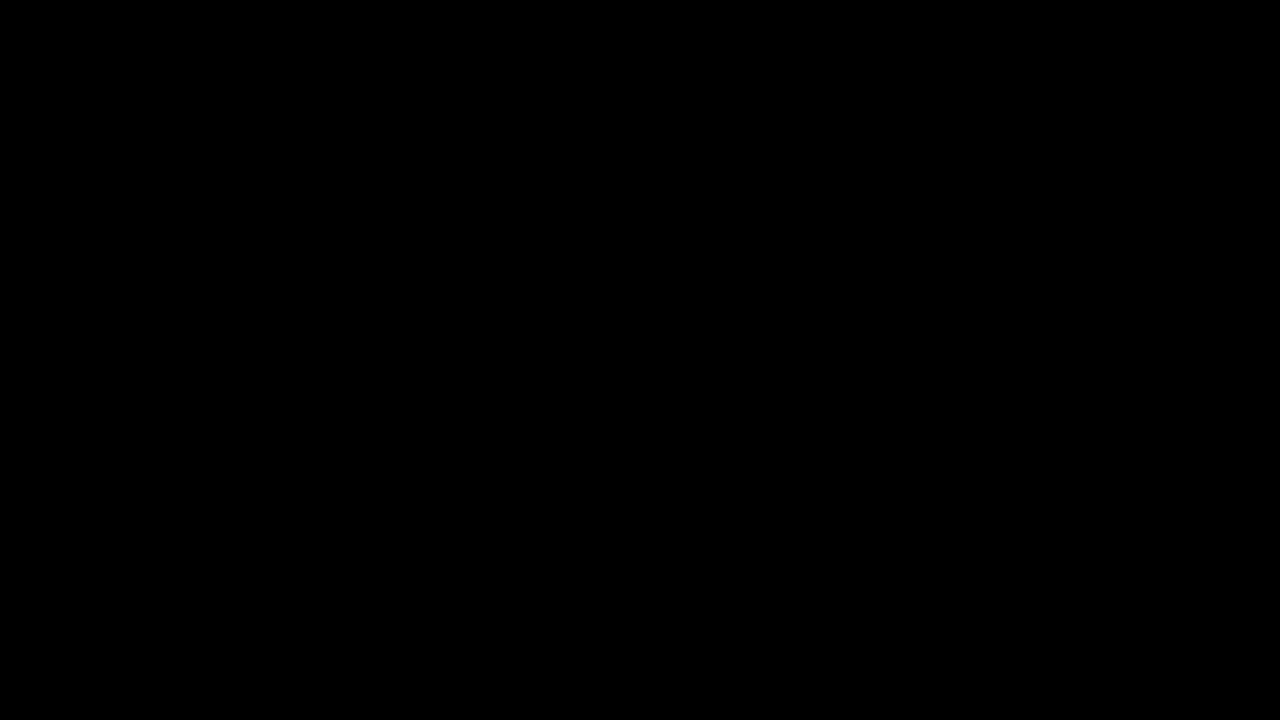

127.0.0.1 - - [19/Jul/2021 04:23:01] "POST /predict HTTP/1.1" 200 -


recieved data:  

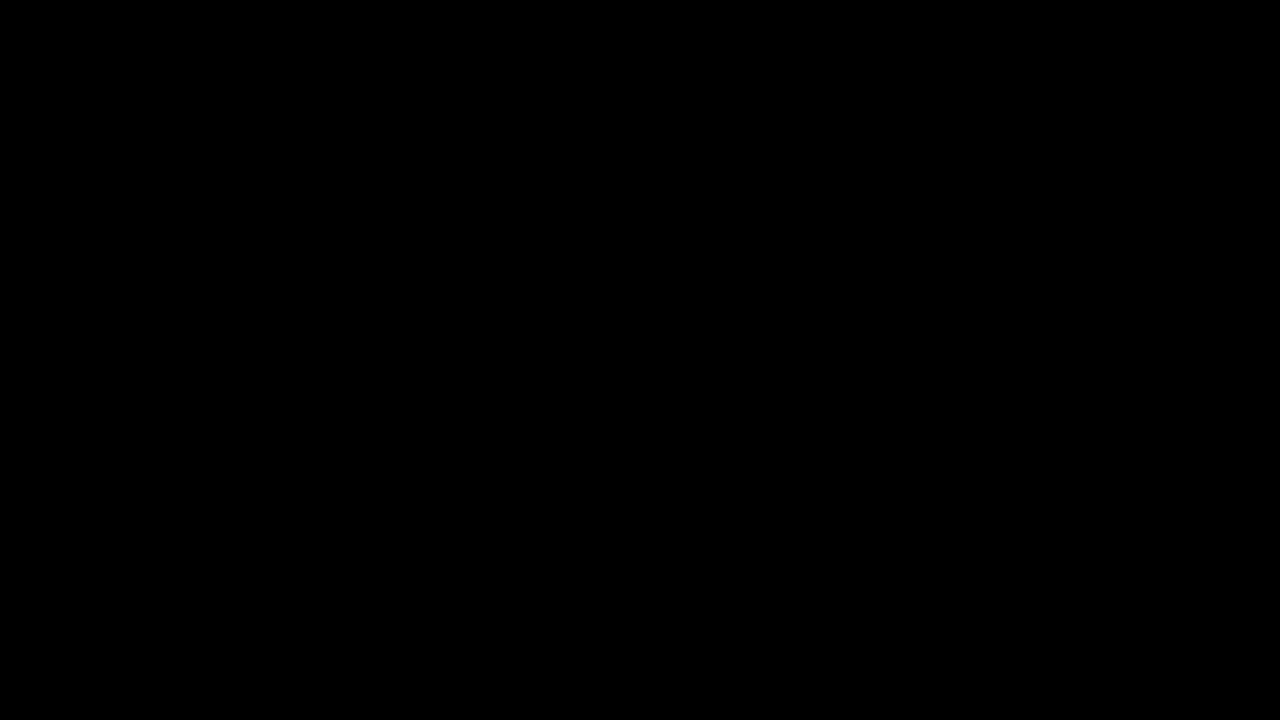

127.0.0.1 - - [19/Jul/2021 04:23:11] "POST /predict HTTP/1.1" 200 -


recieved data:  

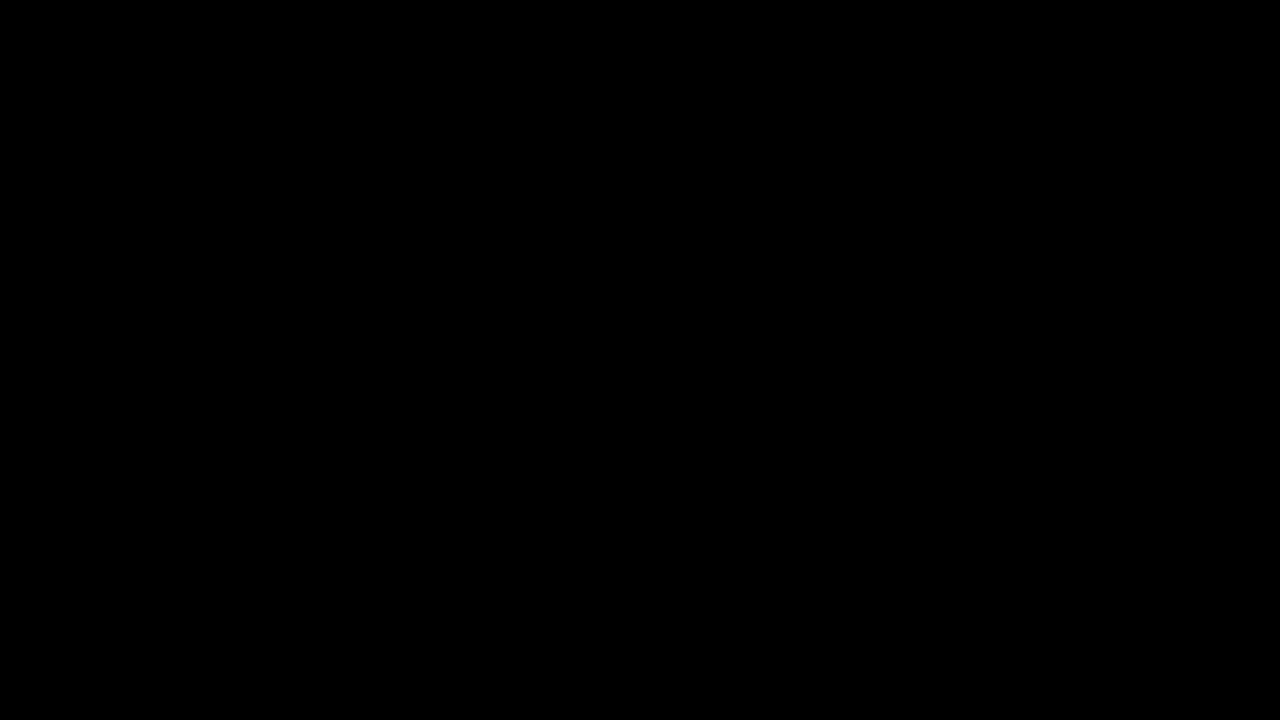

127.0.0.1 - - [19/Jul/2021 04:23:21] "POST /predict HTTP/1.1" 200 -


recieved data:  

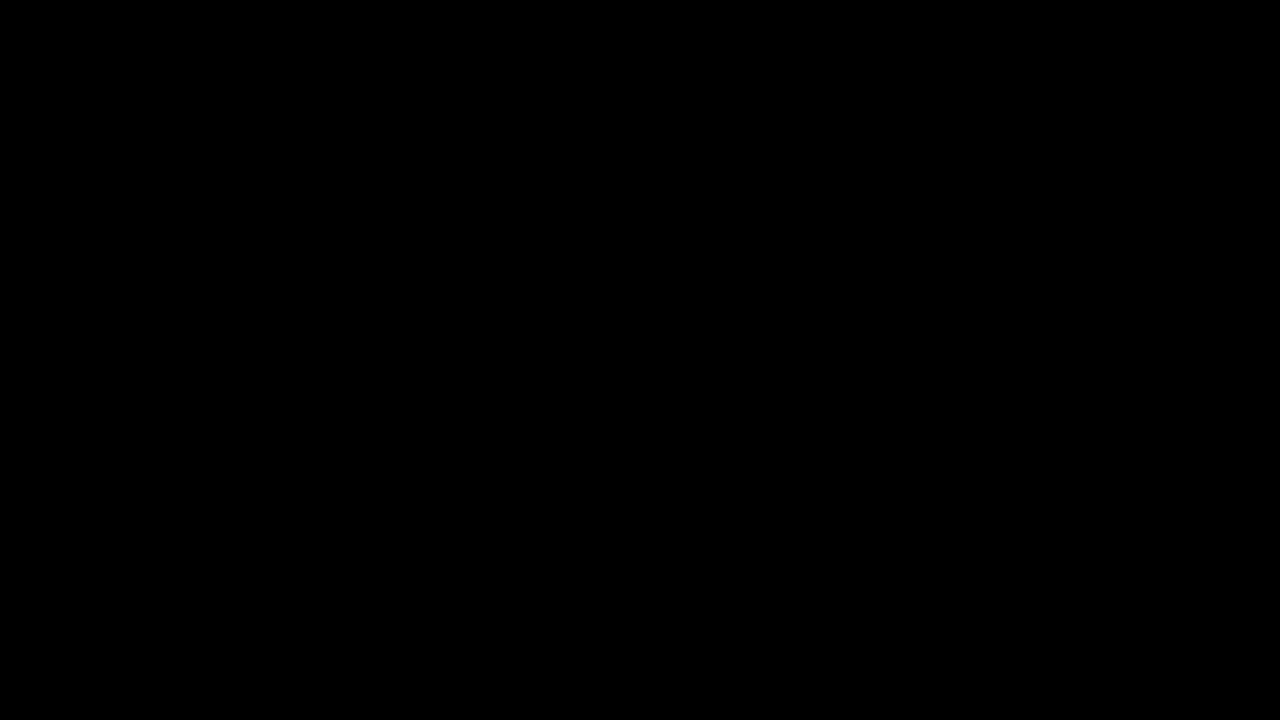

127.0.0.1 - - [19/Jul/2021 04:23:32] "POST /predict HTTP/1.1" 200 -


recieved data:  

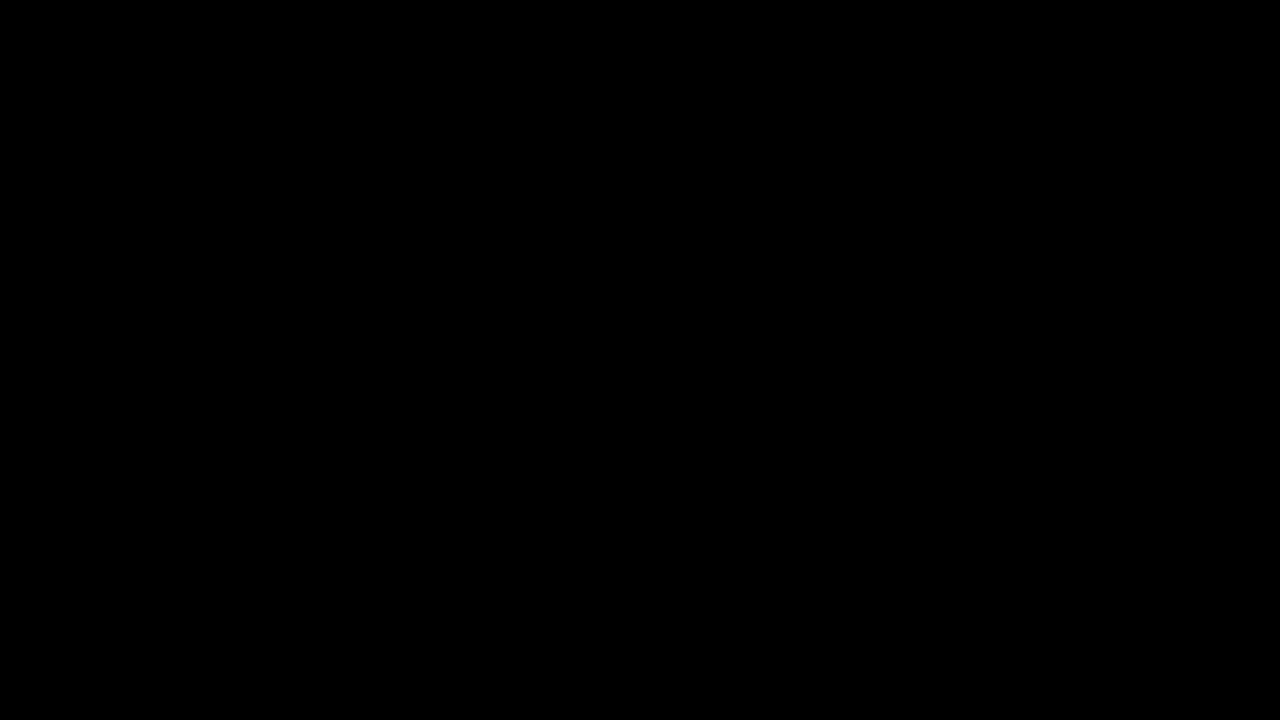

127.0.0.1 - - [19/Jul/2021 04:23:41] "POST /predict HTTP/1.1" 200 -


In [ ]:
from flask import Flask, request, jsonify, render_template
from flask_ngrok import run_with_ngrok
from flask_cors import CORS

app = Flask(__name__)
CORS(app)
#this contains the path of folder that to store the images in
app.config["IMAGE_UPLOADS"] = "/content"
app.config["AUDIO_UPLOADS"]="/content"
run_with_ngrok(app)  # Start ngrok when app is run

#@app.route('/') 
#def home():
#    return render_template('index.html')

@app.route("/predict", methods=['post'])
def predict():
    print("recieved data: ", request.form["image"])

    image_bytes = b64decode(request.form["image"].split(',')[1])
    # convert bytes to numpy array
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    # decode numpy array into OpenCV BGR image
    image = cv2.imdecode(jpg_as_np, flags=1)

    url = request.method
    frameTemp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    frameTemp = cv2.resize(frameTemp, (130, 130))
    try:
      rects = find(frameTemp)
      rects = np.array(rects)
      rects = non_max_suppression_fast(rects, 0.2)
      output=""
      for rect in rects: 
          res,ret=getFaceAlign(frameTemp[rect[0]:rect[1],rect[2]:rect[3]])
          if ret==1:
            #print(rect)
            io.imshow(res)
            pred = pr(res)
            ans = None
            if pred in ['Disgust','Fear','Sad','Angry']:
              ans = 'bad'
            elif pred in ['Surprise' , 'Neutral']:
              ans = 'medium'
            elif pred == 'Happy':
              ans = 'good'             
            output+= ans+" "
            print(ans)
      #return the emotion of the face's image to the html
      if output!="":
        return jsonify(output)
      return jsonify("medium")
    
    except:
        return jsonify("medium")

@app.route('/predictVoice',methods=['POST'])
def predictVoice():
    audio = request.files["file"]
    audiofile=audio.filename
    #save the audio in colab directory /content 
    audio.save(os.path.join(app.config["AUDIO_UPLOADS"], audiofile))
    #dir of audio is in the current directory 
    #convert audio to correct wav file
    newAudio = AudioSegment.from_file(audiofile)
    #overwrite corrupted audio with the corrected audio 
    newAudio.export(audiofile, format="wav")
    emotion_dic=get_emotion_dic("/content/"+audiofile)
    print(emotion_dic)
    return jsonify(emotion_dic)
    

@app.route('/predictSimilarity', methods=['POST'])
def predictSimilarity():
    audio = request.files["file"]
    audiofile=audio.filename
    audio.save(os.path.join(app.config["AUDIO_UPLOADS"], audio.filename))
    # #convert audio to correct wav file
    # newAudio = AudioSegment.from_file(audiofile)
    # #overwrite corrupted audio with the corrected audio 
    # newAudio.export(audiofile, format="wav")

    answer1 = request.form['ans1']
    question=request.form['question']
    print(answer1)

    answer2 = SpeechRecognition("/content/"+audiofile)
    print(answer2)
    prob = predict_similarity(answer1, answer2)
    dic=[question, answer1,prob]
    return jsonify(dic)    

app.run()